# 1. O que são features?

Neste notebook iremos estudar sobre features e a importância delas em tarefas de visão computacional.
Mais especificamente, vamos analisar com mais detalhe as features do tipo ***canto***.

Imagine um jogo de *puzzle* (quebra-cabeça) onde você precisa identificar a posição exata dessas amostras na imagem original.
Quantas você conseguiu acertar?

![building](figures/feature_building.jpg)

Imagine agora que você está na cima de uma montanha.
Você recebeu a imagem da cume de uma outra montanha que você precisa chegar.
Na figura abaixo, a imagem à esquerda é sua foto de referência e a imagem à direita é a cena que você está enxergando.
Repare que algumas amostras podem ser localizadas com maior acurácia do que outras. Por que?

![patches](figures/image_matching.png)

**Resposta:** 

O que estamos fazendo na prática é o ***reconhecimento de padrões*** ou de features que são únicas.
É difícil explicar como o ser humano realiza *sem muito esforço* esta operação.
Digamos que isso já vem codificado no nosso cérebro. 

Considerando as amostras que são mais fáceis de localizar, o que elas têm em comum? O que acontece com tais amostras em imagens deslocadas da mesma cena?


**Resposta:** 

## 1.1. Features do tipo canto e como detectá-las

Primeiro precisamos entender o conceito de borda.
As bordas representam regiões na imagem onde há uma mudança abrupta no nível de intensidade dos píxeis.
Aplicando a primeira derivada no sinal podemos ver que as bordas correspondem a extremos locais. 

![corner](figures/image_signal.png)

Em Processamento Digital de Imagens, o gradiente de uma imagem pode ser obtido a partir da convolução da imagem com kernels conhecidos para detectar bordas.

![corner](figures/convolution.png)

O filtro Sobel, denotado $\Large S=\left ( S_x, S_y \right )^T$ é o mais utilizado em tarefas de detecção de bordas.
Ele permite aproximar o gradiente de uma imagem, denotado $\Large \nabla I = \left ( \frac{\partial I}{\partial u}, \frac{\partial I}{\partial v} \right )^T$, dando as direções de maior variação de intensidade sua magnitude.

$\Large \begin{align}
\frac{\partial I}{\partial u} =
\underbrace{\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}}_{S_x} * I & &
\frac{\partial I}{\partial v} =
\underbrace{\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}}_{S_y:=S_x^T} * I
\end{align}
$

A biblioteca OpenCV `cv2` disponibiliza a função [`Sobel()`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d) que permite calcular o gradiente de uma imagem.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import timeit

# 2. Detectores de cantos

As features do tipo canto normalmente correspondem a regiões da imagem onde existe um alto contraste em relação aos seus píxeis vizinhos.

![corner](figures/pixel_intensity_profile.png)

Assim como as bordas, os cantos podem ser identificados a partir dos gradientes das imagens, a diferença é que em regiões onde existem cantos a magnitude do gradiente varia nas duas direções.

![corner](figures/gradiente.png)

## 2.1. Detector de Harris-Stephens
 Em 1988, Chris Harris e Mike Stephens propuseram um modelo matemático que permite obter a diferença de intensidade em todas as direções, dado um deslocamento $\Large (\Delta x, \Delta y)$.

$\Large f(\Delta x, \Delta y) = \sum_{(x_k,y_k) \in W} (I(x_k, y_k)-I(x_k + \Delta x, y_k + \Delta y))^2$

A partir da expansão de Taylor a função pode ser aproximada para uma formulação matricial.

$\Large f(\Delta x, \Delta y) \approx \begin{pmatrix} \Delta x & \Delta y \end{pmatrix} M \begin{pmatrix} \Delta x \\ \Delta y \end{pmatrix}$ ,

onde $M$ é um tensor de estrutura que descreve a distribuição dos gradientes em torno da vizinhança de um píxel.

$\Large M = \sum_{(x,y)\in W} \begin{bmatrix} I_x^2 & I_xI_y \\ I_xI_y & I_y^2 \end{bmatrix} = \begin{bmatrix} \sum_{(x,y)\in W} I_x^2 & \sum_{(x,y)\in W} I_xI_y \\ \sum_{(x,y)\in W} I_xI_y & \sum_{(x,y)\in W} I_y^2\end{bmatrix}$

A partir do tensor de estrutura $M$, define-se uma função de resposta aos cantos denominada de **resposta de Harris**.

$\Large R = \lambda_1\lambda_2 -\kappa(\lambda_1+\lambda_2)^2=\det(M) - \kappa \text{tr}(M)^2$

![corner](figures/harris_func.png)

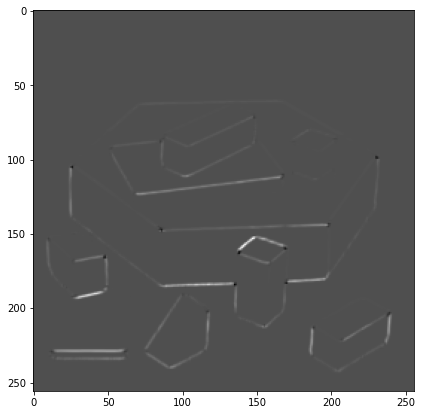

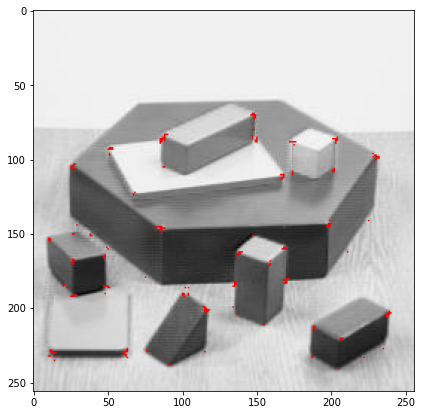

In [2]:
img = cv2.imread('figures/boxes.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)

# Cantos de Harris
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

plt.figure(figsize=(7, 7))
plt.imshow(dst, cmap='gray_r')
plt.show()

# Visualização dos cantos
img[dst > 0.01*dst.max()] = [255,0,0]

plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

## 2.2. Detector de Shi-Tomasi
J. Shi e C. Tomasi propuseram, no artigo intitulado "*Good Features to Track*", uma modificação na resposta de Harris, baseada em uma análise teórica sobre quais features são melhores para serem rastreadas.
Eles propuseram um modelo de movimento para rastrear e monitorar as features ao longo do tempo.
O modelo proposto era equivalente ao tensor de estrutura $M$ proposto inicialmente por Harris.
A partir disso, propuseram uma nova função de resposta aos cantos que, segundo os testes realizados, gera melhores resultados quando comparado com o método de Harris:

$\Large R = \min(\lambda_1,\lambda_2)$

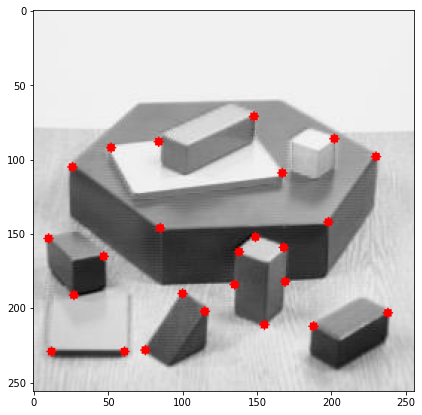

In [3]:
img = cv2.imread('figures/boxes.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray, 25, 0.01, 10)
corners = np.int0(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(img, (x, y), 3, 255, -1)

plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

## 2.3. Features from Accelerated Segment Test (FAST)

Diferente dos outros detectores, Rosten e Drummond propuseram um teste de segmento para classificar um pixel como sendo canto.
O teste consiste em um círculo discretizado em torno do píxel candidato.
O pixel é classificado como canto se existir um arco contínuo de píxeis com pelo menos 9 (12, ou 16) píxeis com maior ou menor intensidade do que o pixel candidato por um limiar.

![corner](figures/fast.jpg)

Para diminuir a grande quantidade de "não cantos" os autores propuseram um teste rápido.
O teste consiste em examinar os pixels nas posições 1, 9, 5 e 13.
Sempre começando pelo 1 e o 9, se verifica se o píxel tem maior ou menor ($\pm$ um determinado limiar) intensidade que o píxel candidato.
O teste do segmento completo somente é realizado se pelo menos três dos píxeis satisfazerem a condição anterior.

Posteriormente, o algoritmo foi acelerado treinando uma árvore de decisão para que sejam feitas o menor número de comparações possíveis durante a classificação. 

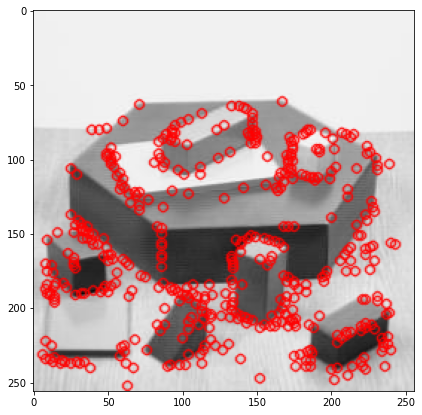

In [4]:
img = cv2.imread('figures/boxes.jpg')

fast = cv2.FastFeatureDetector_create()

kp = fast.detect(img, None)
img2 = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0))

plt.figure(figsize=(7, 7))
plt.imshow(img2)
plt.show()

# 3. Descrição de features

Voltamos ao problema da montanha.
Considere as ROI indicadas na imagem (quadriláteros em vermelho). Pense na proposta de um método que solucione o problema de encontrar aquelas ROI correspondentes em ambas as imagens. Quais seriam os passos?

![patches](figures/image_matching.png)

**Resposta:** 

Considerando a imagem abaixo, qual é a diferença entre as duas amostras?

![sunflower](figures/sunflower.png)

**Resposta:** 

## 3.1. Scale Invariant Feature Transform (SIFT)

Os detectores que vimos até o momento não são invariantes à escala.
Isso é um problema uma vez que em escalas diferentes um canto pode se tornar uma borda, considerando uma mesma janela de detecção.

![corner_scale](figures/corner_scale.png)

O SIFT, diferente dos outros detectores, é um detector de ***blob***.
Um *blob* é uma região de interesse que difere da sua vizinhança em algumas propriedades como intensidade e cor.
Podem ser detectados a partir da convolução da imagem com o operador diferencial de segunda ordem, o *Laplaciano*, denotado por $\nabla^2 I$.

![laplace](figures/laplace_conv.png)

![blob_detect](figures/blob_detect.png)

### 3.1.1 Invariância a escala

Um problema em aplicar operadores laplacianos em uma única escala é que a resposta do operador é fortemente dependente da relação entre o tamanho das regiões de interesse e do tamanho do kernel utilizado no processo de convolução.
Para resolver esse problema podemos fazer uma normalização da resposta do laplaciano, multiplicando-o por $\sigma^2$, para detectar o *blob* na escala apropriada. 

![laplace_norm](figures/laplace_norm.png)

A convolução com o Laplaciano é um processo custoso computacionalmente.
Na prática, o algoritmos SIFT implementa o método de **Diferença de Gaussianas (DoG)** que é uma aproximação do Laplaciano.
A DoG é obtida pela diferença entre imagens suavizadas com $\sigma$ diferentes (*e.g.* $\sigma$ e $k\sigma$).
Esse processo é realizado em conjunto com uma **pirâmide de Gaussianas** que consiste em uma apresentação de uma imagem em múltiplas escalas obtida a partir da suavização e subamostragem (diminuição da resolução) das imagens. 

![pyramid](figures/DoG.jpg)

Tendo as Diferenças de Gaussianas, é feita uma busca pelo **keypoint** que é melhor representado naquela escala.
Por exemplo, um pixel é comparado com os seus 8 vizinhos e com os 9 vizinhos nas escalas adjacentes (superior e inferior na pirâmide).
Se a resposta desse pixel é o máximo local, ele é um potencial keypoint dessa escala.

![search](figures/search.jpg)

A partir dessa abordagem é possível detectar features em escalas diferentes obtendo assim uma lista de $\Large (x,y, \sigma)$, sendo $\Large (x,y)$ as coordenadas em pixeis do ponto e, $\Large \sigma$, a escala em que foi detectado. 

![scale_detect](figures/scale_detect.png)

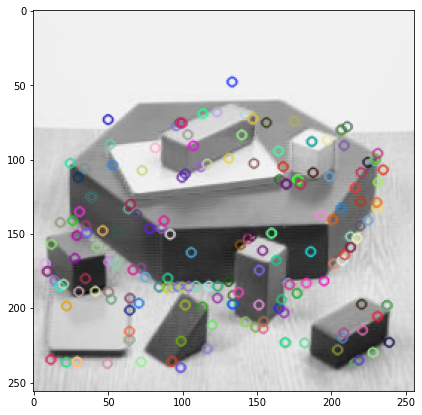

In [5]:
img = cv2.imread('figures/boxes.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp = sift.detect(gray, None)

img=cv2.drawKeypoints(gray, kp, img)

plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

### **3.1.2. Invariância a rotação**

Primeiro precisamos entender o conceito de **Histograma de Gradientes Orientados (HOG)**.
O HOG consiste em um histograma formado a partir das orientações dos gradientes da vizinhança de um keypoint.
Consiste em 36 barras, cobrindo um range de 360 graus ($0$ a $2\pi$), e cada amostra adicionada ao histograma é ponderado pela magnitude do gradiente e escala em que o keypoint foi detectado. 

![hog](figures/HOG.png)

O estágio final do algoritmo do SIFT é a geração de um descritor do keypoint, que consiste basicamente em um vetor de 128 dimensões.
Com isso o SIFT deixa de ser um simples detector de features e passa a ser um detector e descritor de features.

Com as informações de localização, escala e orientação é possível criar um sistema de coordenadas local que deveria ser similar em diferentes pontos de vista.
O descritor em si, consiste em um histograma formado pelos gradientes.
Uma janela de $16\times16$ é dividida em 4 grades de células.
Em cada célula, é feito o cálculo do HOG com histograma de ângulos dividido em 8 orientações, obtendo assim um vetor de 128 ($4\times4\times8) posições.

![cells](figures/cells.png)

![hog_bin](figures/hog_bin.png)

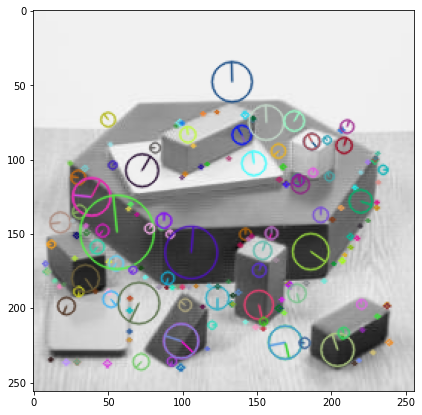

In [6]:
img = cv2.imread('figures/boxes.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp = sift.detect(gray, None)

img = cv2.drawKeypoints(gray, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

Voltando ao nosso problema inicial da montanha, como você estabeleceria uma correspondência entre duas amostras utilizando SIFT?

**Resposta:** 

## 3.2. Oriented FAST and Rotated BRIEF (ORB)

Como discutido anteriormente o SIFT usa um vetor de 128 dimensões para descrever a vizinhança dos pontos, utilizando a representação de números em pontos flutuantes.
Isso quer dizer que para cada vetor, ele calcula 512 bytes, o que o torna inviável para aplicações com restrições computacionais. 

### 3.2.1 Binary Robust Independent Elementary Features (BRIEF)

O BRIEF é um descritor binário que foi proposto como uma alternativa a descritores como o SIFT.
Basicamente o BRIEF usa strings binárias para descrever a vizinhança da feature, tornando-o mais eficiente tanto na criação quanto no processo de correspondência. 

![binary_string](figures/brief.png)

Basicamente o que o algoritmo faz é uma comparação em pares dos pixels dentro de uma janela.
Considerando uma amostra $\Large \mathbf{p}$, o teste binário é definido da seguinte forma:

$\Large \tau (\mathbf{p};\mathrm{x},\mathrm{y}):= \left\{\begin{matrix}
1 & \mathbf{p}(\mathrm{x})<\mathbf{p}(\mathrm{y})  \\ 
0 & \mathbf{p}(\mathrm{x})\geq \mathbf{p}(\mathrm{y})
\end{matrix}\right.$

onde $\mathbf{p}(\mathrm{x})$ é a intensidade de $\mathbf{p}$ no ponto $\mathrm{x}$ e $\mathbf{p}(\mathrm{x})$ é a intensidade de $\mathbf{p}$ no ponto $\mathrm{x}$.

O vetor descritor é definido como um vetor de $n$ testes binários:

$\Large f_{n}(\mathbf{p}):= \sum_{1\leq i\leq n}^{}2^{i-1}\tau (\mathbf{p};\mathrm{x}_{i},\mathrm{y}_{i})$

No artigo, foram testadas várias abordagens para selecionar os $n$ pares de pontos para realizar o teste 

![binary_test](figures/brief_test.jpeg)

O que gerou melhores resultados em termos de reconhecimento foi a primeira estratégia, em que considerando uma amostra $\Large \mathbf{p}$ de tamanho $\Large (S\times S)$, os pares $\Large (x,y)$ são escolhidos de forma aleatória a partir de uma distribuição gaussiana com $\Large \sigma=0.04S^{2}$.

In [10]:
img = cv2.imread('figures/boxes.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fast = cv2.FastFeatureDetector_create()
kp = fast.detect(img, None)

brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
kp, des = brief.compute(img, kp)

print("Tamanho do descritor: ", brief.descriptorSize())
print( "Formato do vetor: ", des.shape)

Tamanho do descritor:  32
Formato do vetor:  (331, 32)


### 3.2.2 oFAST (FAST Keypoint Orientation) e rBRIEF (Rotation-Aware Brief)

Como vimos anteriormente, o FAST, diferente do Harris, não gera um resposta de canto e nem produz features em múltiplas escalas assim como o SIFT.
Para resolver isso os autores propuseram usar a abordagem de pirâmide de imagens para obter as features em múltiplas resoluções e aplicaram a função de resposta do Harris para filtrar os $N$ pontos com melhor resposta de canto em cada nível da pirâmide.
Para obter a orientação do keypoint eles usaram o momento da amostra da vizinhança do keypoint. 

O BRIEF originalmente não é invariante à rotação, o que faz com que o desempenho dele caia drasticamente com imagens rotacionadas por alguns graus.
Para resolver estes problemas eles utilizam a própria orientação do keypoint para rotacionar os elementos do teste binário.
Para cada feature o conjunto de $n$ teste binário na posição $(x_{i}, y_{i})$, define-se a matriz $2 \times n$:

$\Large S = \begin{pmatrix}
\mathrm{x}_{1},\cdots ,\mathrm{x}_{n}\\ 
\mathrm{y}_{1},\cdots ,\mathrm{y}_{n}
\end{pmatrix}$

A partir da orientação do keypoint é feito o rotacionamento do conjunto $S$:

$\Large S_{\theta }=\mathbf{R}_{\theta }S $

E com isso o operador fica da seguinte forma:

$\Large g_{n}(\mathbf{p},\theta ):= f_{n}(\mathbf{p})|(\mathrm{x_{i}}, \mathrm{y_{i}})\in S_{\theta }$

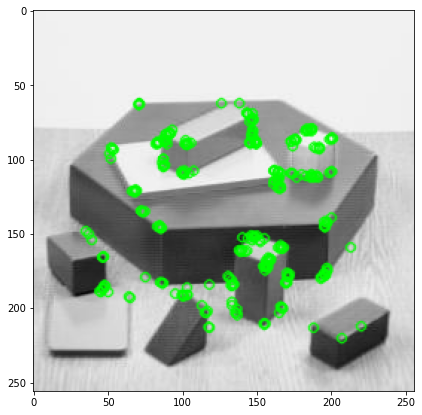

In [13]:
img = cv2.imread('figures/boxes.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create()
kp = orb.detect(gray, None)
kp, des = orb.compute(img, kp)

img2 = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)

plt.figure(figsize=(7, 7))
plt.imshow(img2)
plt.show()

# 4. Desafio de correspondência de features

Tudo o que a gente viu na aula de hoje, embora possa ser simples, é uma das primeiras etapas em qualquer pipeline de Visão Robótica e outras aplicações de reconhecimento de padrões.
De nada adianta apenas detectarmos as features, muitas dessas tarefas de alto nível demandam a correspondência dessas features em imagens de uma mesma cena capturadas em diferentes pontos de vista. 

**Desafio:** O desafio consiste em definir qual e a melhor estratégia de extração de features para fazer a correspondência entre as imagens utilizando a primeira como referência (*i.e.*, fazer a comparação da primeira com as demais).
Precisa levar em consideração a razão entre números de keypoints e número de correspondências, o tempo de execução e o erro médio da distância entre os descritores.
Para isso iremos utilizar o BF matcher do OpenCV, que faz a comparação de cada vetor com os demais e retorna os pares com menor distância.
O objeto [`BFMatcher`](https://docs.opencv.org/4.6.0/d3/da1/classcv_1_1BFMatcher.html) recebe dois argumentos `normType` e `crossCheck`, que deve ser sempre setado para verdadeiro.
O [`normType`](https://docs.opencv.org/4.6.0/d2/de8/group__core__array.html#gad12cefbcb5291cf958a85b4b67b6149f) é basicamente a métrica de distância utilizada para calcular a distância entre os vetores, ele pode e deve ser alterado de acordo com o descritor utilizado e isso deve estar na análise de vocês.
Os mais utilizados são `cv.NORM_L1`, `cv.NORM_L2`, `cv.NORM_HAMMING`, `cv.NORM_HAMMING2`. 

**Classes de refência**:
- [Harris](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)
- [Shi-Tomasi](https://docs.opencv.org/4.6.0/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)
- [FAST](https://docs.opencv.org/4.6.0/df/d74/classcv_1_1FastFeatureDetector.html)
- [SIFT](https://docs.opencv.org/4.6.0/d0/d13/classcv_1_1Feature2D.html)
- [BRIEF](https://docs.opencv.org/4.6.0/d1/d93/classcv_1_1xfeatures2d_1_1BriefDescriptorExtractor.html)
- [ORB](https://docs.opencv.org/4.6.0/db/d95/classcv_1_1ORB.html)

In [15]:
img1 = cv2.imread('dataset/img1.ppm')
img2 = cv2.imread('dataset/img7.ppm') # em cada teste esta imagem deve ser trocada!!!

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

tic = timeit.default_timer()

#### Seu código ####

#### Estatísticas e visualizações ####

toc = timeit.default_timer()
matches = sorted(matches, key=lambda x:x.distance)

img3 = cv2.drawMatches(gray1, kp1, gray2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(7, 7))
plt.imshow(img3)
plt.show()

time = toc - tic

print("Tempo de processamento %f s" % time)
print("Quantidade de keypoints:", len(kp))
print("Quantidade de matches:", len(matches))
print("Proporção de matches obtidos:", len(matches)/len(kp))
mean = sum(x.distance for x in matches)/len(matches)
print("Erro médio das distâncias", mean)

NameError: name 'matches' is not defined